### Test env for Stochastic Trend algo using MC and option priciple for optimal portfolio weighting

In [15]:
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import pandas_ta as ta
import alpaca_trade_api as tradeapi
import os
from dotenv import load_dotenv
from alpaca_trade_api.rest import TimeFrame
import datetime as dt
import pytz
from time import sleep
from scipy import stats
from matplotlib import pyplot as plt
import statsmodels.api as sm


In [4]:
load_dotenv()
API_KEY = os.getenv("ALPACA_API_KEY")
SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")
END_POINT = os.getenv("ALPACA_END_POINT")

In [5]:
api = tradeapi.REST(API_KEY, SECRET_KEY, END_POINT)

In [90]:
def adf_test(timeseries: list[float])-> bool:
    y_lag = list(timeseries[:-1])  # y(t-1)
    delta_y = list(np.diff(timeseries))  # Δy(t)
    X = sm.add_constant(y_lag) 
    model = sm.OLS(delta_y, X).fit()
    return model.pvalues[1] > 0.05

def autoregressive_trend_direction(timeseries: list[float])->int:
    y_lag = list(timeseries[:-1])  # y(t-1)
    y = list(timeseries[1:])
    X = sm.add_constant(y_lag)  # Adds intercept
    model = sm.OLS(y, X).fit()
    phi = model.params[1]
    
    if phi > 0: return 1 # Buy
    return -1 # Sell

In [69]:
def get_stocks(tickers: list[str], timeframe: str, start: str, end: str) -> pd.DataFrame:
    """
    timeframe: 1min | 5min | 15min | 1hour | 1day | 1week
    """
    stock_dfs = []
    
    for ticker in tickers:
        bars = api.get_bars(ticker, timeframe, start, end).df
        bars.reset_index(inplace=True)
        stock_df = pd.DataFrame({
            'timestamp': bars['timestamp'],
            ticker: bars['close']
        })
        stock_dfs.append(stock_df)

    merged_df = stock_dfs[0]
    
    for stock_df in stock_dfs[1:]:
        merged_df = pd.merge(merged_df, stock_df, on='timestamp', how='inner')

    merged_df.reset_index(drop=True, inplace=True)
    
    return merged_df

In [143]:
tickers = ['AAPL', 'AMZN', 'V', 'XOM', 'DIS', 'KO']
start = '2024-11-01'
end = '2024-12-01'

stocks = get_stocks(tickers, '1min', start, end)
stocks

,timestamp,AAPL,AMZN,V,XOM,DIS,KO
0,2024-11-01 12:00:00+00:00,222.5000,200.0800,290.900,119.1999,96.2001,65.5200
1,2024-11-01 13:29:00+00:00,220.9700,198.9100,287.570,120.0100,95.5200,65.3900
2,2024-11-01 13:30:00+00:00,221.4300,198.4900,288.990,119.3800,95.5392,65.4400
3,2024-11-01 13:31:00+00:00,222.0700,199.8300,288.780,118.9489,94.9500,65.4250
4,2024-11-01 13:32:00+00:00,221.2600,199.9827,289.270,119.0650,95.2300,65.3600
...,...,...,...,...,...,...,...
7711,2024-11-29 17:56:00+00:00,237.4779,207.9150,315.070,118.2250,117.6700,64.0800
7712,2024-11-29 17:57:00+00:00,237.4800,207.9350,315.195,118.1450,117.6550,64.1100
7713,2024-11-29 17:58:00+00:00,237.4750,207.9500,315.080,118.1000,117.6800,64.1100
7714,2024-11-29 17:59:00+00:00,237.3400,207.9100,315.120,118.0600,117.6300,64.1300


In [145]:
df = stocks.copy()
del df['timestamp']

for ticker in tickers:
    df[ticker + '_DF'] = np.nan
    df[ticker + '_AR(1)'] = np.nan
    for i in range(14, len(df)):
        df.loc[i, ticker + '_DF'] = adf_test(list(df[i-14: i+1][ticker]))
        df.loc[i, ticker + '_AR(1)'] = autoregressive_trend_direction(list(df[i-14: i+1][ticker]))
df

C:\Users\naths\AppData\Local\Temp\ipykernel_1684\3366114490.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[i, ticker + '_DF'] = adf_test(list(df[i-14: i+1][ticker]))
C:\Users\naths\AppData\Local\Temp\ipykernel_1684\3366114490.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[i, ticker + '_DF'] = adf_test(list(df[i-14: i+1][ticker]))
C:\Users\naths\AppData\Local\Temp\ipykernel_1684\3366114490.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype

,AAPL,AMZN,V,XOM,DIS,KO,AAPL_DF,AAPL_AR(1),AMZN_DF,AMZN_AR(1),V_DF,V_AR(1),XOM_DF,XOM_AR(1),DIS_DF,DIS_AR(1),KO_DF,KO_AR(1)
0,222.5000,200.0800,290.900,119.1999,96.2001,65.5200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,220.9700,198.9100,287.570,120.0100,95.5200,65.3900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,221.4300,198.4900,288.990,119.3800,95.5392,65.4400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,222.0700,199.8300,288.780,118.9489,94.9500,65.4250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,221.2600,199.9827,289.270,119.0650,95.2300,65.3600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7711,237.4779,207.9150,315.070,118.2250,117.6700,64.0800,True,1.0,True,1.0,True,1.0,True,1.0,False,1.0,True,1.0
7712,237.4800,207.9350,315.195,118.1450,117.6550,64.1100,True,1.0,True,1.0,True,1.0,True,1.0,False,1.0,True,1.0
7713,237.4750,207.9500,315.080,118.1000,117.6800,64.1100,True,1.0,True,1.0,True,1.0,True,1.0,False,1.0,True,1.0
7714,237.3400,207.9100,315.120,118.0600,117.6300,64.1300,True,1.0,True,1.0,True,1.0,True,1.0,False,-1.0,True,1.0


In [146]:
for ticker in tickers:
    df.loc[df[ticker + '_DF'] == 1 & (df[ticker + '_AR(1)'] == 1), ticker + '_signal'] = 1  # Buy
    df.loc[df[ticker + '_DF'] == 0 | (df[ticker + '_AR(1)'] == -1), ticker + '_signal'] = -1  # Sell
    df[ticker + '_norm'] = (df[ticker] / df.loc[0, ticker] -1)*100

df

,AAPL,AMZN,V,XOM,DIS,KO,AAPL_DF,AAPL_AR(1),AMZN_DF,AMZN_AR(1),...,AMZN_signal,AMZN_norm,V_signal,V_norm,XOM_signal,XOM_norm,DIS_signal,DIS_norm,KO_signal,KO_norm
0,222.5000,200.0800,290.900,119.1999,96.2001,65.5200,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000
1,220.9700,198.9100,287.570,120.0100,95.5200,65.3900,NaN,NaN,NaN,NaN,...,NaN,-0.584766,NaN,-1.144723,NaN,0.679615,NaN,-0.706964,NaN,-0.198413
2,221.4300,198.4900,288.990,119.3800,95.5392,65.4400,NaN,NaN,NaN,NaN,...,NaN,-0.794682,NaN,-0.656583,NaN,0.151091,NaN,-0.687006,NaN,-0.122100
3,222.0700,199.8300,288.780,118.9489,94.9500,65.4250,NaN,NaN,NaN,NaN,...,NaN,-0.124950,NaN,-0.728773,NaN,-0.210571,NaN,-1.299479,NaN,-0.144994
4,221.2600,199.9827,289.270,119.0650,95.2300,65.3600,NaN,NaN,NaN,NaN,...,NaN,-0.048631,NaN,-0.560330,NaN,-0.113171,NaN,-1.008419,NaN,-0.244200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7711,237.4779,207.9150,315.070,118.2250,117.6700,64.0800,True,1.0,True,1.0,...,1.0,3.915934,1.0,8.308697,1.0,-0.817870,-1.0,22.317960,1.0,-2.197802
7712,237.4800,207.9350,315.195,118.1450,117.6550,64.1100,True,1.0,True,1.0,...,1.0,3.925930,1.0,8.351667,1.0,-0.884984,-1.0,22.302368,1.0,-2.152015
7713,237.4750,207.9500,315.080,118.1000,117.6800,64.1100,True,1.0,True,1.0,...,1.0,3.933427,1.0,8.312135,1.0,-0.922736,-1.0,22.328355,1.0,-2.152015
7714,237.3400,207.9100,315.120,118.0600,117.6300,64.1300,True,1.0,True,1.0,...,1.0,3.913435,1.0,8.325885,1.0,-0.956293,1.0,22.276380,1.0,-2.121490


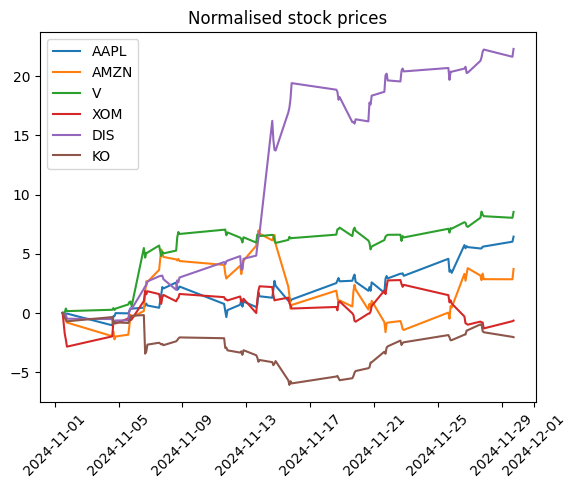

In [150]:
downsampled_timestamps = stocks['timestamp'][::100]
downsampled_values = {ticker: df[ticker + '_norm'][::100] for ticker in tickers}
for ticker in tickers:
    plt.plot(downsampled_timestamps, downsampled_values[ticker], label=ticker)

plt.xticks(rotation=45)
plt.legend()
plt.title("Normalised stock prices")
plt.show()


### Historic Brownian motion analysis with Stochastic Drift

In [151]:
drift_data = {}

df_historic = get_stocks(tickers, '1min', '2024-10-01', '2024-10-31')
stock_prices = df_historic[tickers]
stock_corr = stock_prices.corr()

for ticker in tickers:
    time = [i+1 for i in range(len(df_historic)-1)]
    S = list(df_historic[ticker][1:])
    S_lag = list(df_historic[ticker][:-1])
    X = pd.DataFrame({'Time': time, 'S_lag': S_lag})
    X = sm.add_constant(X)
    S_t = sm.OLS(S, X).fit()
    ser = ser = np.sqrt(S_t.mse_resid)
    drift_data[ticker] = {
        'ser': ser,
        'Time': S_t.params['Time'],
        'S_lag': S_t.params['S_lag'],
        'Drift': S_t.params['const'],
        'Drift_SE': S_t.bse['const'],
    }
    drift_t = [S[i] - time[i]*drift_data[ticker]['Time'] - S_lag[i]*drift_data[ticker]['S_lag'] - np.array(S_t.resid)[i] for i in range(len(S))]
    drift_resid = pd.DataFrame({"Drift": drift_t, "Resid": S_t.resid})
    drift_data[ticker]['Drift_Resid_Corr'] = drift_resid.corr()

pd.DataFrame(drift_data)


,AAPL,AMZN,V,XOM,DIS,KO
ser,0.152493,0.179714,0.189643,0.092153,0.052519,0.043637
Time,-0.0,0.000003,0.000003,-0.000002,0.000001,-0.000001
S_lag,0.999582,0.996897,0.998308,0.997003,0.998164,0.999056
Drift,0.096095,0.567379,0.466006,0.37355,0.170931,0.066971
Drift_SE,0.127963,0.164327,0.167598,0.078854,0.055864,0.03411
Drift_Resid_Corr,Drift Resid Drift 1.000000 -0.0...,Drift Resid Drift 1.000000 0.0...,Drift Resid Drift 1.000000 0.0...,Drift Resid Drift 1.000000 0.0...,Drift Resid Drift 1.000000 -0.0...,Drift Resid Drift 1.00000 -0.0006...


#### Simulate trading by optimizing portfolio weights by using N=100 MC sims

In [ ]:
N = 100
M = len(df)
T = 15
t = [i+1 for i in range(15)]
portfolio_value = 10000 # 10,000 USD
df['weights'] = 0

for i in range(M):
    data = df.loc[i]
    price_patterns = {ticker: np.zeros(N) for ticker in tickers}
    ticker_count = {ticker: 0 for ticker in tickers}
    u_t_matrix = np.random.normal(size=(N,T, len(tickers)))
    L_u = np.linalg.cholesky(stock_corr)
    for j in range(N):
        for k in range(T):
            u_t_matrix[j][k] = np.inner(L_u, u_t_matrix[j][k])

    for (q, ticker) in enumerate(tickers):
        if data[ticker + '_signal'] == 1:
            for j in range(N):
                S_t = [0 for _ in range(15)]
                S_t[0] = data[ticker]
                for k in range(1, T):
                    drift = np.random.normal(drift_data[ticker]['Drift'], 0.5*drift_data[ticker]['Drift_SE'])
                    u = drift_data[ticker]['ser']*u_t_matrix[j][k][q]
                    L = np.linalg.cholesky(drift_data[ticker]['Drift_Resid_Corr'])
                    dift, u_t = np.dot(L, np.array([drift, u]))
                    S_t[k] = drift + (k+M)*drift_data[ticker]['Time'] + S_t[k-1]*drift_data[ticker]['S_lag'] + u_t
                price_patterns[ticker][j] = 100*(S_t[-1] / S_t[0] - 1 )

    price_patterns = pd.DataFrame(price_patterns)
    
    price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1)
    counts = price_patterns['Best_Ticker'].value_counts()
    
    weights = {}
    for ticker in tickers:
        if ticker in counts:
            weights[ticker] = counts[ticker] / N
    df.loc[i, 'weights'] = str(weights)
    
    

KeyboardInterrupt: 